In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''


## Gaussian Processes

In Section 6.1, we introduced kernels by applying the concept of duality to a non-probabilistic model for regression. Here we extend the role of kernels to probabilistic discriminative models, leading to the framework of **Gaussian processes**. We shall thereby see how kernels arise naturally in a Bayesian setting.

## Linear Regression Revisited

In order to motivate the **Gaussian process** viewpoint, let us return to the linear regression example and re-derive the predictive distribution by working in terms of distributions over functions $ y(x, w) $. This will provide a specific example of a Gaussian process.

Consider a model defined in terms of a linear combination of $ M $ fixed basis functions given by the elements of the vector $ \phi(x) $ so that

$$
y(x) = w^T \phi(x)
$$

where $ x $ is the input vector and $ w $ is the $ M $-dimensional weight vector. Now consider a prior distribution over $ w $ given by an isotropic Gaussian of the form

$$
p(w) = \mathcal{N}(w|0, \alpha^{-1} I)
$$

governed by the hyperparameter $ \alpha $, which represents the precision (inverse variance) of the distribution. For any given value of $ w $, the definition $ y(x) = w^T \phi(x) $ defines a particular function of $ x $. The probability distribution over $ w $ therefore induces a probability distribution over functions $ y(x) $.

### Joint Distribution of Function Values

In practice, we wish to evaluate this function at specific values of $ x $, for example, at the training data points $ x_1, \dots, x_N $. We are therefore interested in the joint distribution of the function values $ y(x_1), \dots, y(x_N) $, which we denote by the vector $ y $ with elements

$$
y_n = y(x_n), \quad n = 1, \dots, N.
$$

From $ y(x) = w^T \phi(x) $, this vector is given by

$$
y = \Phi w
$$

where $ \Phi $ is the design matrix with elements $ \Phi_{nk} = \phi_k(x_n) $.

We can find the probability distribution of $ y $ as follows. Since $ y $ is a linear combination of Gaussian distributed variables (given by the elements of $ w $), it is itself Gaussian. Therefore, we need to find its mean and covariance, which are given by

$$
E[y] = \Phi E[w] = 0
$$

and

$$
\text{cov}[y] = E[yy^T] = \Phi E[ww^T] \Phi^T = \Phi \Phi^T = K
$$

where $ K $ is the Gram matrix with elements

$$
K_{nm} = k(x_n, x_m) = \phi(x_n)^T \phi(x_m)
$$

and $ k(x, x') $ is the kernel function. This model provides us with a particular example of a **Gaussian process**.

In general, a **Gaussian process** is defined as a probability distribution over functions $ y(x) $ such that the set of values $ y(x_1), \dots, y(x_N) $ evaluated at an arbitrary set of points $ x_1, \dots, x_N $ jointly have a Gaussian distribution. In cases where the input vector $ x $ is two-dimensional, this may also be known as a **Gaussian random field**.

### Gaussian Process Definition

A key point about Gaussian stochastic processes is that the joint distribution over $ N $ variables $ y_1, \dots, y_N $ is specified completely by the second-order statistics, namely the mean and the covariance. In most applications, we will not have any prior knowledge about the mean of $ y(x) $, so by symmetry, we take it to be zero. This is equivalent to choosing the mean of the prior over weight values $ p(w | \alpha) $ to be zero in the basis function viewpoint.

The specification of the Gaussian process is then completed by giving the covariance of $ y(x) $ evaluated at any two values of $ x $, which is given by the kernel function

$$
E[y(x_n) y(x_m)] = k(x_n, x_m)
$$

For the specific case of a Gaussian process defined by the linear regression model with a weight prior, the kernel function is given by

$$
k(x_n, x_m) = \phi(x_n)^T \phi(x_m)
$$

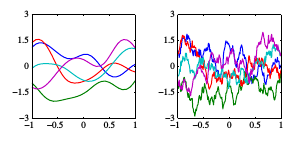

Fig.4 Samples from Gaussian processes for a ‘Gaussian’ kernel (left) and an exponential kernel (right).



We can also define the kernel function directly, rather than indirectly through a choice of basis function. Fig.4 shows samples of functions drawn from Gaussian processes for two different choices of kernel function. The first of these is a **Gaussian kernel** of the form

$$
k(x, x') = \exp \left( - \frac{|x - x'|^2}{2\sigma^2} \right)
$$

and the second is the **exponential kernel** given by

$$
k(x, x') = \exp \left( - \theta |x - x'| \right)
$$

which corresponds to the **Ornstein-Uhlenbeck process**, originally introduced by Uhlenbeck and Ornstein (1930) to describe Brownian motion.



/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


ValueError: operands could not be broadcast together with shapes (100,) (10000,) 

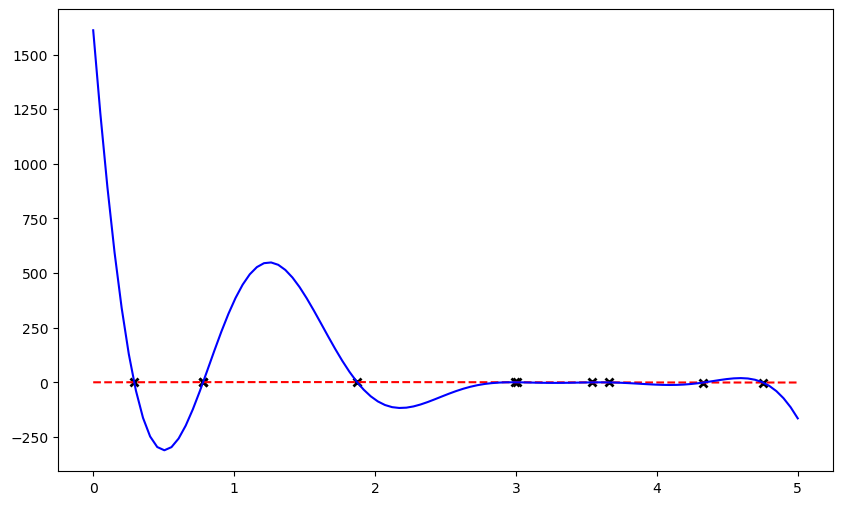

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the kernel function
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """
    Radial Basis Function (RBF) kernel, also known as Gaussian kernel.
    k(x1, x2) = sigma_f^2 * exp(-||x1 - x2||^2 / (2 * length_scale^2))
    """
    sqdist = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# Gaussian Process Regression
def gaussian_process(X_train, y_train, X_test, kernel, sigma_y=1e-8):
    """
    Gaussian Process Regression implementation.
    
    Parameters:
    - X_train: Training inputs (N x D).
    - y_train: Training outputs (N x 1).
    - X_test: Test inputs (M x D).
    - kernel: Kernel function.
    - sigma_y: Noise variance.
    
    Returns:
    - mu_s: Predictive mean (M x 1).
    - cov_s: Predictive covariance (M x M).
    """
    # Compute the covariance matrices
    K = kernel(X_train, X_train) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_test)
    K_ss = kernel(X_test, X_test) + sigma_y**2 * np.eye(len(X_test))
    
    # Compute the mean and covariance of the posterior
    K_inv = np.linalg.inv(K)
    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

# Generate sample data
np.random.seed(42)
X_train = np.random.uniform(0, 5, (10, 1))  # 10 training points in [0, 5]
y_train = np.sin(X_train) + 0.1 * np.random.randn(*X_train.shape)  # Noisy sine function

X_test = np.linspace(0, 5, 100).reshape(-1, 1)  # 100 test points in [0, 5]

# Perform Gaussian Process Regression
length_scale = 1.0
sigma_f = 1.0
mu_s, cov_s = gaussian_process(X_train, y_train, X_test, 
                               lambda x1, x2: rbf_kernel(x1, x2, length_scale, sigma_f))

# Extract the standard deviation from the covariance
std_s = np.sqrt(np.diag(cov_s))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'kx', mew=2, label="Training Points")
plt.plot(X_test, np.sin(X_test), 'r--', label="True Function")
plt.plot(X_test, mu_s, 'b', label="Mean Prediction")
plt.fill_between(X_test.flatten(), 
                 (mu_s - 2 * std_s).flatten(), 
                 (mu_s + 2 * std_s).flatten(), 
                 color='blue', alpha=0.2, label="Confidence Interval (2 std)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian Process Regression")
plt.show()


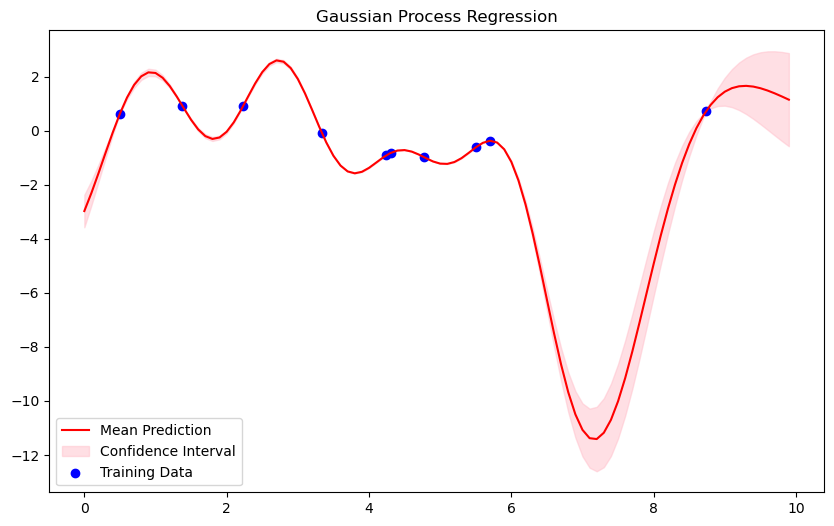

In [3]:
import math
import random
import matplotlib.pyplot as plt

# Helper function to compute the squared exponential kernel
def squared_exponential_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """
    Computes the squared exponential (Gaussian) kernel between two points.
    """
    diff = x1 - x2
    return sigma_f ** 2 * math.exp(-0.5 * (diff ** 2) / (length_scale ** 2))

# Matrix inversion using Gaussian elimination with partial pivoting
def invert_matrix(matrix):
    """
    Compute the inverse of a square matrix using Gaussian elimination with partial pivoting.
    """
    n = len(matrix)
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    augmented = [matrix[i] + identity[i] for i in range(n)]
    
    # Gaussian elimination with pivoting
    for i in range(n):
        # Pivot selection
        max_row = max(range(i, n), key=lambda k: abs(augmented[k][i]))
        augmented[i], augmented[max_row] = augmented[max_row], augmented[i]
        
        # Make the diagonal element 1
        diag_element = augmented[i][i]
        for j in range(2 * n):
            augmented[i][j] /= diag_element
        
        # Make other elements in the column 0
        for k in range(n):
            if k != i:
                factor = augmented[k][i]
                for j in range(2 * n):
                    augmented[k][j] -= factor * augmented[i][j]
    
    # Extract the inverse matrix
    return [row[n:] for row in augmented]

# Helper function to multiply two matrices
def multiply_matrices(A, B):
    """
    Multiplies two matrices A and B.
    """
    rows_A, cols_A = len(A), len(A[0])
    rows_B, cols_B = len(B), len(B[0])
    
    if cols_A != rows_B:
        raise ValueError("Number of columns in A must equal number of rows in B")
    
    result = [[0 for _ in range(cols_B)] for _ in range(rows_A)]
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i][j] += A[i][k] * B[k][j]
    return result

# Gaussian Process Regression
def gaussian_process(x_train, y_train, x_test, length_scale=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Performs Gaussian Process Regression.
    """
    n_train = len(x_train)
    n_test = len(x_test)
    
    # Compute the kernel matrix for training data
    K = [[squared_exponential_kernel(x_train[i], x_train[j], length_scale, sigma_f) for j in range(n_train)] for i in range(n_train)]
    
    # Add noise variance to the diagonal
    for i in range(n_train):
        K[i][i] += sigma_y
    
    # Compute the kernel between training and test data
    K_s = [[squared_exponential_kernel(x_train[i], x_test[j], length_scale, sigma_f) for j in range(n_test)] for i in range(n_train)]
    
    # Compute the kernel for the test data
    K_ss = [[squared_exponential_kernel(x_test[i], x_test[j], length_scale, sigma_f) for j in range(n_test)] for i in range(n_test)]
    
    # Invert the training kernel matrix
    K_inv = invert_matrix(K)
    
    # Compute the mean of the posterior
    K_s_T = [[K_s[j][i] for j in range(n_train)] for i in range(n_test)]  # Transpose of K_s
    mu_s = multiply_matrices(K_s_T, multiply_matrices(K_inv, [[y] for y in y_train]))
    mu_s = [row[0] for row in mu_s]  # Flatten to a list
    
    # Compute the covariance of the posterior
    temp = multiply_matrices(K_s_T, K_inv)
    cov_s = [[K_ss[i][j] - sum(temp[i][k] * K_s[k][j] for k in range(n_train)) for j in range(n_test)] for i in range(n_test)]
    
    return mu_s, cov_s

# Generate synthetic data
def generate_data():
    """
    Generates synthetic data for regression.
    """
    x_train = [random.uniform(0, 10) for _ in range(10)]
    y_train = [math.sin(x) + random.gauss(0, 0.1) for x in x_train]
    x_test = [i / 100.0 * 10 for i in range(100)]
    return x_train, y_train, x_test

# Plot the results
def plot_gp(x_train, y_train, x_test, mu_s, cov_s):
    """
    Plots the results of Gaussian Process Regression.
    """
    std_s = [math.sqrt(max(cov_s[i][i], 0)) for i in range(len(cov_s))]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_test, mu_s, 'r-', label='Mean Prediction')
    plt.fill_between(x_test, [mu_s[i] - 2 * std_s[i] for i in range(len(mu_s))], 
                     [mu_s[i] + 2 * std_s[i] for i in range(len(mu_s))], color='pink', alpha=0.5, label='Confidence Interval')
    plt.scatter(x_train, y_train, c='blue', label='Training Data')
    plt.legend()
    plt.title('Gaussian Process Regression')
    plt.show()

# Main execution
x_train, y_train, x_test = generate_data()
mu_s, cov_s = gaussian_process(x_train, y_train, x_test)
plot_gp(x_train, y_train, x_test, mu_s, cov_s)


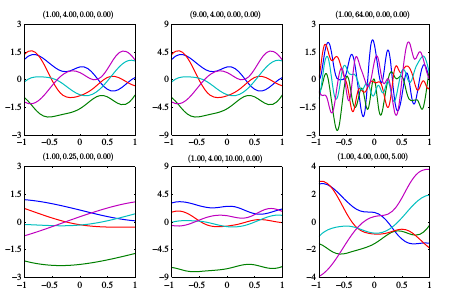
## Gaussian Processes for Regression

To model regression problems using Gaussian Processes (GPs), we consider observations $ t_n $ that are related to the underlying function values $ y_n = y(x_n) $ through additive Gaussian noise:

$$
t_n = y_n + \epsilon_n,
$$

where $ \epsilon_n \sim \mathcal{N}(0, \beta^{-1}) $ is an independent noise term with precision $ \beta $.

### Likelihood of Observed Data

Given the Gaussian noise model, the conditional likelihood of the observed target values $ t = (t_1, \dots, t_N)^\top $ given $ y = (y_1, \dots, y_N)^\top $ is:

$$
p(t|y) = \mathcal{N}(t|y, \beta^{-1}I_N),
$$

where \( I_N \) is the $ N \times N $ identity matrix.

### Marginal Prior over \( y \)

The GP defines a prior over functions \( y(x) \), which induces a joint Gaussian prior over the values of \( y \) at the observed input points:

$$
p(y) = \mathcal{N}(y|0, K),
$$

where $ K $ is the covariance matrix with elements $ K_{nm} = k(x_n, x_m) $ determined by the kernel function $ k(x_n, x_m) $.

### Marginalizing \( y \)

To find the marginal distribution of \( t \), we integrate out \( y \):

$$
p(t) = \int p(t|y)p(y) \, dy = \mathcal{N}(t|0, C),
$$

where the covariance matrix \( C \) is given by:

$$
C(x_n, x_m) = k(x_n, x_m) + \beta^{-1} \delta_{nm}.
$$

Here, \( \delta_{nm} \) is the Kronecker delta.

### Kernel Function

A commonly used kernel function combines an exponential quadratic term with linear and constant components:

$$
k(x_n, x_m) = \theta_0 \exp \left( -\frac{\|x_n - x_m\|^2}{2\theta_1^2} \right) + \theta_2 + \theta_3 x_n^\top x_m.
$$

- The term involving $ \theta_3 $ corresponds to a linear parametric model.

### Predictive Distribution

To predict the target $ t_{N+1} $ for a new input $ x_{N+1} $, we compute the conditional distribution:

$$
p(t_{N+1}|t) = \mathcal{N}(t_{N+1}|\mu_{N+1}, \sigma_{N+1}^2).
$$

#### Partitioning the Covariance Matrix

The joint distribution over \( t_1, \dots, t_N, t_{N+1} \) is:

$$
p(t_{N+1}) = \mathcal{N}(t_{N+1}|0, C_{N+1}),
$$

where the covariance matrix \( C_{N+1} \) is partitioned as:

$$
C_{N+1} =
\begin{bmatrix}
C_N & k \\
k^\top & c
\end{bmatrix}.
$$

- $ C_N $: Covariance matrix of training data.  
- $ k $: Covariance vector between training points and $ x_{N+1} $.  
- $ c $: Covariance at $ x_{N+1} $, i.e., $ k(x_{N+1}, x_{N+1}) $.

#### Predictive Mean and Variance

Using properties of Gaussian distributions, the predictive mean and variance are:

$$
\mu_{N+1} = k^\top C_N^{-1} t,
$$

$$
\sigma_{N+1}^2 = c - k^\top C_N^{-1} k.
$$


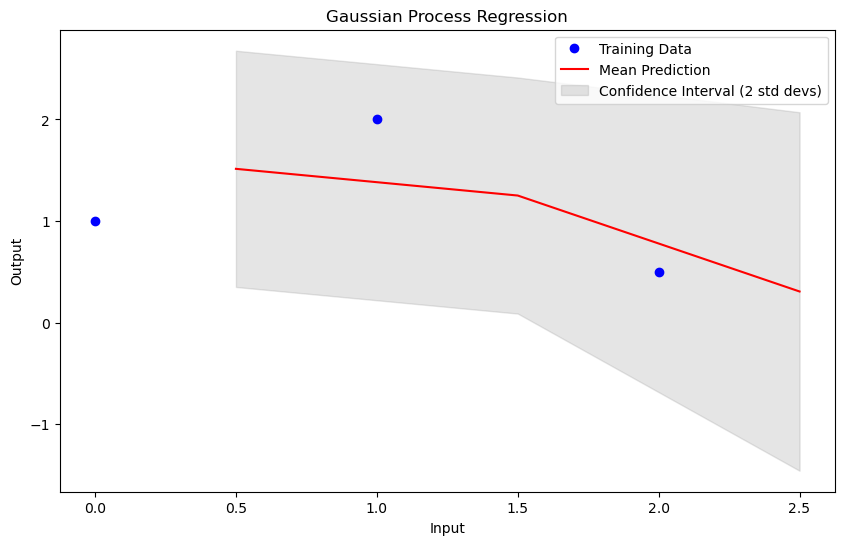

In [4]:
import math
import matplotlib.pyplot as plt

# Define the kernel function
def kernel(x1, x2, theta):
    # Squared Exponential Kernel + Linear Term + Constant
    sq_dist = sum((x1[i] - x2[i]) ** 2 for i in range(len(x1)))
    return (
        theta[0] * math.exp(-0.5 * sq_dist / theta[1])
        + theta[2]
        + theta[3] * sum(x1[i] * x2[i] for i in range(len(x1)))
    )

# Matrix inversion using Gaussian elimination (for simplicity)
def matrix_inverse(mat):
    n = len(mat)
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    for i in range(n):
        diag_elem = mat[i][i]
        for j in range(n):
            mat[i][j] /= diag_elem
            identity[i][j] /= diag_elem
        for k in range(n):
            if k != i:
                factor = mat[k][i]
                for j in range(n):
                    mat[k][j] -= factor * mat[i][j]
                    identity[k][j] -= factor * identity[i][j]
    return identity

# Matrix multiplication
def matrix_multiply(A, B):
    rows_A, cols_A = len(A), len(A[0])
    rows_B, cols_B = len(B), len(B[0])
    if cols_A != rows_B:
        raise ValueError("Matrix dimensions do not match for multiplication")
    return [
        [sum(A[i][k] * B[k][j] for k in range(cols_A)) for j in range(cols_B)]
        for i in range(rows_A)
    ]

# Main Gaussian Process Regression function
def gaussian_process_regression(X_train, y_train, X_test, theta, beta):
    # Construct the covariance matrix for training data
    K = [
        [kernel(X_train[i], X_train[j], theta) for j in range(len(X_train))]
        for i in range(len(X_train))
    ]

    # Add noise term to covariance matrix
    for i in range(len(K)):
        K[i][i] += 1 / beta

    # Invert the covariance matrix
    K_inv = matrix_inverse([row[:] for row in K])  # Copy to avoid modifying K

    # Compute the mean and variance for test data
    predictions = []
    for x_star in X_test:
        # Compute k (covariance vector between training and test point)
        k = [kernel(X_train[i], x_star, theta) for i in range(len(X_train))]

        # Predictive mean
        k_T = [[k[i]] for i in range(len(k))]
        mean = sum(k[i] * sum(K_inv[i][j] * y_train[j] for j in range(len(y_train))) for i in range(len(k)))

        # Predictive variance
        c = kernel(x_star, x_star, theta) + 1 / beta
        variance = c - sum(k[i] * sum(K_inv[i][j] * k[j] for j in range(len(k))) for i in range(len(k)))

        predictions.append((mean, variance))

    return predictions

# Example data and parameters
X_train = [[0.0], [1.0], [2.0]]
y_train = [1.0, 2.0, 0.5]
X_test = [[0.5], [1.5], [2.5]]
theta = [1.0, 1.0, 1.0, 1.0]  # Hyperparameters for the kernel
beta = 5.0  # Noise precision

# Perform Gaussian Process Regression
predictions = gaussian_process_regression(X_train, y_train, X_test, theta, beta)

# Plot the results
means = [p[0] for p in predictions]
std_devs = [math.sqrt(p[1]) for p in predictions]
X_test_flat = [x[0] for x in X_test]

plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in X_train], y_train, "bo", label="Training Data")
plt.plot(X_test_flat, means, "r-", label="Mean Prediction")
plt.fill_between(
    X_test_flat,
    [m - 2 * s for m, s in zip(means, std_devs)],
    [m + 2 * s for m, s in zip(means, std_devs)],
    color="gray",
    alpha=0.2,
    label="Confidence Interval (2 std devs)",
)
plt.legend()
plt.title("Gaussian Process Regression")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()
